## What is the decision tree?

![](https://i.imgur.com/5C4ryqb.png)

In [1]:
# Import package
import matplotlib.pyplot as plt
from sklearn import datasets

# Loading data
iris = datasets.load_iris()
X = iris['data'][:, 2:]
y = iris['target']
X.shape, y.shape

((150, 2), (150,))

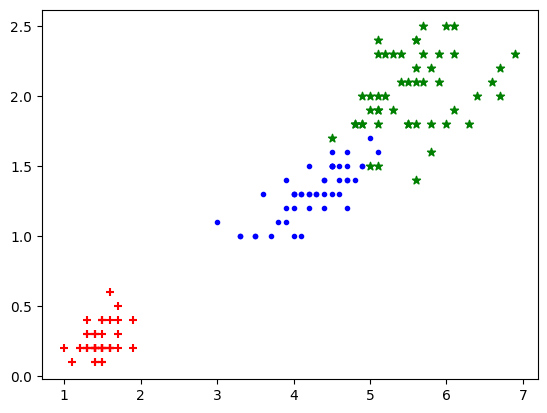

In [2]:
# plot data
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='r', marker='+')
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='b', marker='.')
plt.scatter(X[y == 2, 0], X[y == 2, 1], color='g', marker='*')
plt.show()

In [8]:
# Create model
from sklearn.tree import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier(max_depth=2, criterion='entropy')
dt_classifier.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=2)

In [9]:
import numpy as np


def plot_decision_boundary(model, axis):
    x0, x1 = np.meshgrid(
        np.linspace(axis[0], axis[1], int((axis[1] - axis[0]) * 100)).reshape(-1, 1),
        np.linspace(axis[2], axis[3], int((axis[3] - axis[2]) * 100)).reshape(-1, 1)
    )
    X_new = np.c_[x0.ravel(), x1.ravel()]
    y_predict = model.predict(X_new)
    zz = y_predict.reshape(x0.shape)
    from matplotlib.colors import ListedColormap
    custom_cmap = ListedColormap(['#EF9A9A', '#FFF59D', '#90CAF9'])
    plt.contourf(x0, x1, zz, linewidth=5, cmap=custom_cmap)

C:\Users\myxc\AppData\Local\Temp\ipykernel_8108\1609706217.py:14: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contourf(x0, x1, zz, linewidth=5, cmap=custom_cmap)


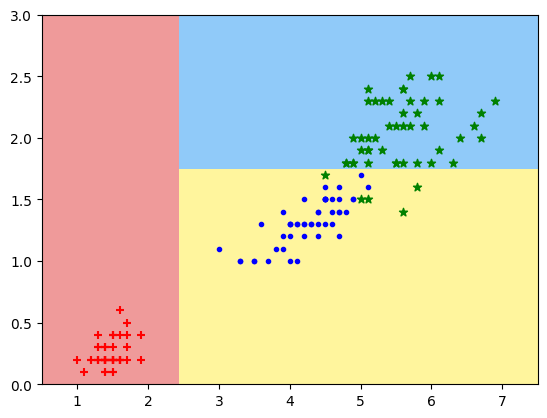

In [10]:
plot_decision_boundary(dt_classifier, axis=[.5, 7.5, 0, 3])
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='r', marker='+')
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='b', marker='.')
plt.scatter(X[y == 2, 0], X[y == 2, 1], color='g', marker='*')
plt.show()

![](https://i.imgur.com/xqTUDta.png)

- 非参数学习算法
- 可以解决分类问题
- 天然可以解决多分类问题
- 也可以解决回归问题
- 非常好的可解释性

## 信息熵

熵在信息论中代表随机变量不确定度的度量。

熵越大，数据的不确定性越高；熵越小，数据的不确定性越低。

![](https://i.imgur.com/RfZ8Yvb.png)

特别的，针对二分类问题：

$$H = - x \log ( x ) - ( 1 - x ) \log ( 1 - x )$$

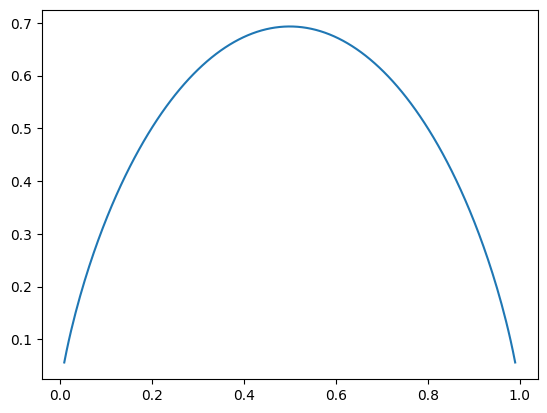

In [14]:
def binary_entropy(p):
    return -p * np.log(p) - (1 - p) * np.log(1 - p)


x = np.linspace(0.01, 0.99, 200)

plt.plot(x, binary_entropy(x))
plt.show()
# 由图中可以看出来，针对二分类问题，在“五五分”的情况下，信息熵最大；而在“一家独大”的情况下，信息熵会尽力小。